In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
import pickle
#pd.set_option('display.max_colwidth', None)
# !pip install spacy -q
# !python -m spacy download en_core_web_sm -q

In [4]:
complaints_orig = pd.read_csv('../data/complaints.csv')
complaints = complaints_orig
complaints

,Consumer complaint narrative,Issue
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam
2,I have a particular account that is stating th...,Incorrect information on your report
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report
...,...,...
353427,Collections account I have no knowledge of,Attempts to collect debt not owed
353428,"Dear CFPB Team, The reason for my complaint is...",Attempts to collect debt not owed
353429,FRCA violations : Failing to Follow Debt Dispu...,Attempts to collect debt not owed
353430,"My Father, a XXXX XXXX acquired an HECM rever...",Struggling to pay mortgage


# Cleanup

In [5]:
#rename the column
complaints = complaints.rename(columns={"Consumer complaint narrative": "complaint"})

In [6]:
complaints.Issue.unique()

array(['Incorrect information on your report', 'Fraud or scam',
       'Attempts to collect debt not owed', 'Communication tactics',
       'Struggling to pay mortgage'], dtype=object)

In [7]:
complaints_ORIG =complaints

In [8]:
complaints_cleaned =complaints

In [9]:
complaints_cleaned

,complaint,Issue
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam
2,I have a particular account that is stating th...,Incorrect information on your report
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report
...,...,...
353427,Collections account I have no knowledge of,Attempts to collect debt not owed
353428,"Dear CFPB Team, The reason for my complaint is...",Attempts to collect debt not owed
353429,FRCA violations : Failing to Follow Debt Dispu...,Attempts to collect debt not owed
353430,"My Father, a XXXX XXXX acquired an HECM rever...",Struggling to pay mortgage


# Cleanup - clean_text

In [10]:
import string
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
REPLACE_XX = re.compile('XX(X+|[/.])')
REPLACE_NUMBERS = re.compile('[0-9]')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = REPLACE_XX.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    #text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = REPLACE_NUMBERS.sub('', text) # delete numbers which are in REPLACE_NUMBERS from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    


In [11]:
#Call the clean_text function
complaints['comp_cleaned'] = complaints['complaint'].apply(clean_text)

In [12]:
complaints.Issue.value_counts()

Issue
Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: count, dtype: int64

In [13]:
# PerctOfRows = 0.8
# # #@sampled_df = complaints[complaints['Issue'] == 'Incorrect information on your report'].sample(frac=PerctOfRows)
# complaints_1 = complaints[complaints['Issue'] == 'Incorrect information on your report'].sample(frac=PerctOfRows)
# complaints_2 = complaints[complaints['Issue'] == 'Attempts to collect debt not owed'].sample(frac=PerctOfRows)
# complaints_3 = complaints[complaints['Issue'] == 'Communication tactics'].sample(frac=PerctOfRows)
# complaints_4 = complaints[complaints['Issue'] == 'Struggling to pay mortgage'].sample(frac=PerctOfRows)
# complaints_5 = complaints[complaints['Issue'] == 'Fraud or scam'].sample(frac=PerctOfRows)

In [14]:
#complaints_5

In [15]:
# frames = [complaints_1, complaints_2, complaints_3, complaints_4, complaints_5  ]
# complaints = pd.concat(frames)
# complaints

In [16]:
# complaints = complaints.reset_index(drop=True)

In [17]:
complaints['category_id'] = complaints['Issue'].factorize()[0]
category_id_df = complaints[['Issue', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Issue']].values)
complaints

,complaint,Issue,comp_cleaned,category_id
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report,name complaint made error neither made third p...,0
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam,searched pointed website legitimately believed...,1
2,I have a particular account that is stating th...,Incorrect information on your report,particular account stating owe listed credit r...,0
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed,supplied proof doctrine estoppel silence engel...,2
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report,hello im writing regarding account credit repo...,0
...,...,...,...,...
353427,Collections account I have no knowledge of,Attempts to collect debt not owed,collections account knowledge,2
353428,"Dear CFPB Team, The reason for my complaint is...",Attempts to collect debt not owed,dear cfpb team reason complaint tried resolve ...,2
353429,FRCA violations : Failing to Follow Debt Dispu...,Attempts to collect debt not owed,frca violations failing follow debt dispute pr...,2
353430,"My Father, a XXXX XXXX acquired an HECM rever...",Struggling to pay mortgage,father acquired hecm reverse mortgage property...,4


In [18]:
# from sklearn.utils import shuffle
# complaints = shuffle(complaints)
# complaints


In [19]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(complaints.comp_cleaned).toarray()
# labels = complaints.category_id
# features.shape

In [20]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 10
# for Issue, category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names_out())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   #Trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
#   print("# '{}':".format(Issue))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
#   #print("  . Most correlated Trigrams:\n. {}".format('\n. '.join(Trigrams[-N:])))

In [21]:
def getWordsInDFByList(dfSource, search_words, category):
    
    df = dfSource[dfSource['Issue'] == category]
    # use str.count to count the occurrences of each search word
    counts = pd.Series({word: df['comp_cleaned'].str.count(word).sum() for word in search_words})
    
   
    
    counts = pd.DataFrame(counts).reset_index()
    #rename columns
    cols = ['word','count']
    counts.columns = cols

    counts = counts.sort_values(by=['count'] ,ascending=False)
    # print the counts
    #print(counts)
    return counts

# Function pretty_conf_matrix

In [22]:
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# df_labels_unique = dataframe unique label values
#cmap_color_pl - sns color pallete e.g. "Blues", "Reds"
# title - string Title
def pretty_conf_matrix(cf_matrix, df_labels_unique, cmap_color_pl, title) : 
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)


    ax = sns.heatmap(cf_matrix, annot=True, square= True, cmap='Blues', cbar=False, fmt='d', xticklabels=df_labels_unique,
                     yticklabels=df_labels_unique )
    

    # set x-axis label and ticks. 
    #ax.set_xlabel("Predicted ", fontsize=14, labelpad=20)
    #ax.xaxis.set_ticklabels(['Negative', 'Positive'])

    # set y-axis label and ticks
    #ax.set_ylabel("Actual ", fontsize=14, labelpad=20)
    #ax.yaxis.set_ticklabels(['Negative', 'Positive'])

    ax.set_yticklabels(ax.get_yticklabels(), va='center')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # set plot title
    ax.set_title(title, fontsize=14, pad=20)

    plt.show()

# EDA

In [23]:
complaints.shape

(353432, 4)

In [24]:
complaints[complaints.isna().any(axis=1)]

,complaint,Issue,comp_cleaned,category_id


In [25]:
complaints.head(2).T 

,0,1
complaint,My name is XXXX XXXX this complaint is not mad...,I searched on XXXX for XXXXXXXX XXXX and was ...
Issue,Incorrect information on your report,Fraud or scam
comp_cleaned,name complaint made error neither made third p...,searched pointed website legitimately believed...
category_id,0,1


In [26]:
complaints.Issue.value_counts()

Issue
Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: count, dtype: int64

Text(0, 0.5, 'Issue Type')

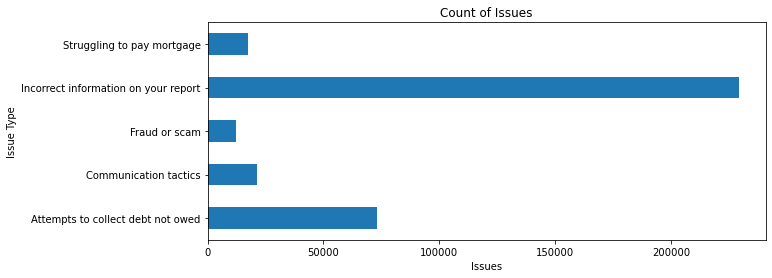

In [27]:
ax = complaints.Issue.value_counts().sort_index()\
.plot(kind='barh', title="Count of Issues", figsize=(10,4))
ax.set_xlabel('Issues')
ax.set_ylabel('Issue Type')
#plt.xticks(rotation = 75)

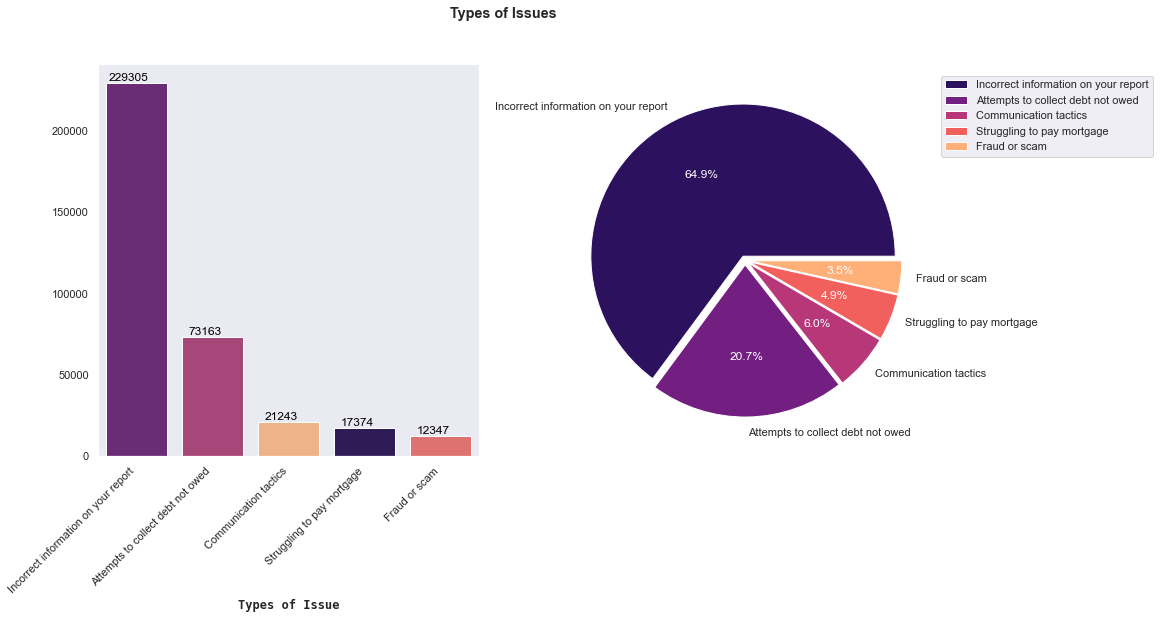

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15,8))
fig.autofmt_xdate(rotation=45)
x=complaints['Issue'].value_counts().index
y=complaints['Issue'].value_counts().values.tolist()
data = complaints.groupby("Issue").size()
sns.set(style="dark", color_codes=True)

pal = sns.color_palette("magma", len(data))
rank = data.argsort().argsort() 
sns.barplot(x=x,y=y,palette=np.array(pal[::-1])[rank],ax = ax[0])
for p in ax[0].patches:
        ax[0].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')
ax[0].set_xlabel('Types of Issue', weight='semibold', fontname = 'monospace')
_, _, autotexts= ax[1].pie(y, labels = x, colors = pal, autopct='%1.1f%%',
        explode=[0.03 for i in complaints['Issue'].value_counts().index])
for autotext in autotexts:
    autotext.set_color('white')
plt.legend(bbox_to_anchor=(1, 1))
plt.suptitle ('Types of Issues',weight = 'bold')

plt.show()

# Generate Word Cloud

In [125]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def GetTP(df, itemIssue, NumOfTopsWords):
    import nltk
    import pandas as pd
    from nltk.corpus import stopwords
    from collections import Counter

    # Load the dataframe
    df = df[df['Issue'] == itemIssue]

    # Define the stop words to exclude
    stop_words = set(stopwords.words('english'))

    # Tokenize the category column and exclude stopwords
    category_words = [word.lower() for word in nltk.word_tokenize(df['comp_cleaned'].str.cat(sep=' ')) if word.lower() not in stop_words]
    #category_words
    # Retrieve the top 100 most common words
    top_words = Counter(category_words).most_common(NumOfTopsWords)
    top_words=pd.DataFrame(top_words, columns=['word','count'], index=None).sort_values(by=['count'] ,ascending=False)
    #print( itemIssue + " - Top words")
    
    #print(top_words['word'])
    return top_words['word'].values.tolist()

def GenerateWordCloud(MaxWordCloudWords):
    issues = complaints.Issue.unique()
    for issue in issues:    
        word_list = GetTP(complaints,issue, MaxWordCloudWords)
        print (lst)
        text = ' '.join(word_list)
        # Create a WordCloud object
        wordcloud = WordCloud(width=600, height=530, max_words=MaxWordCloudWords,colormap="Dark2").generate(text)
        # Display the generated word cloud using matplotlib
        plt.figure(figsize=(10,8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(issue,fontsize=16)
        plt.axis('off')
        plt.show()

['loan', 'mortgage', 'modification']


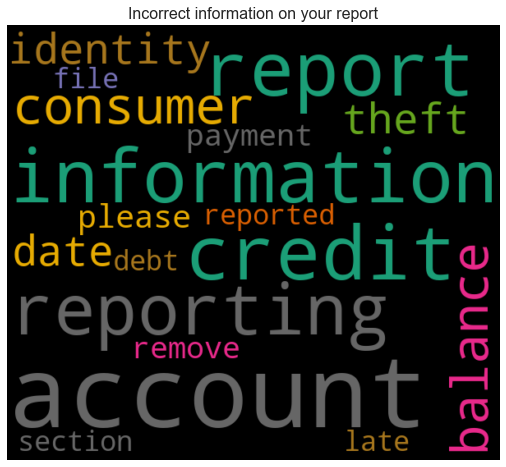

['loan', 'mortgage', 'modification']


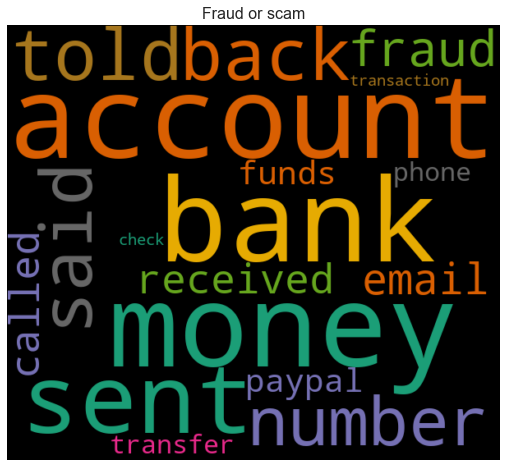

['loan', 'mortgage', 'modification']


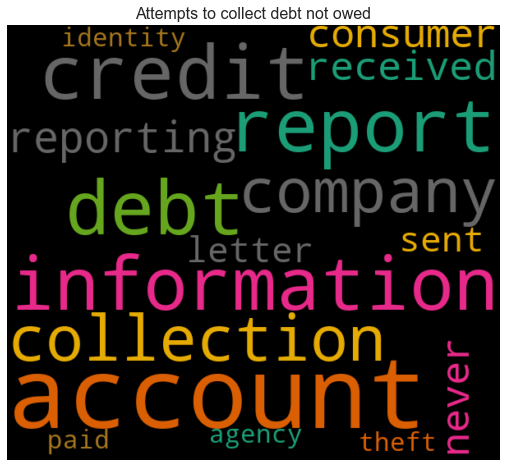

['loan', 'mortgage', 'modification']


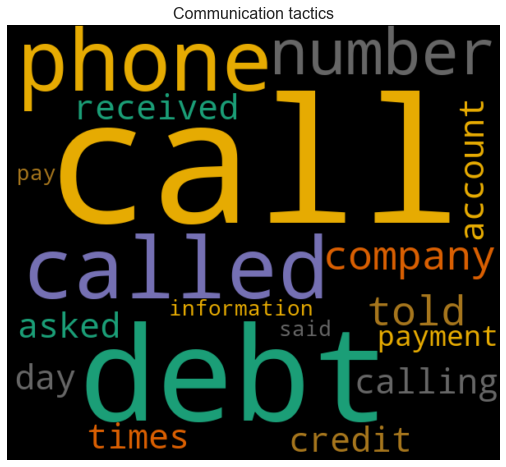

['loan', 'mortgage', 'modification']


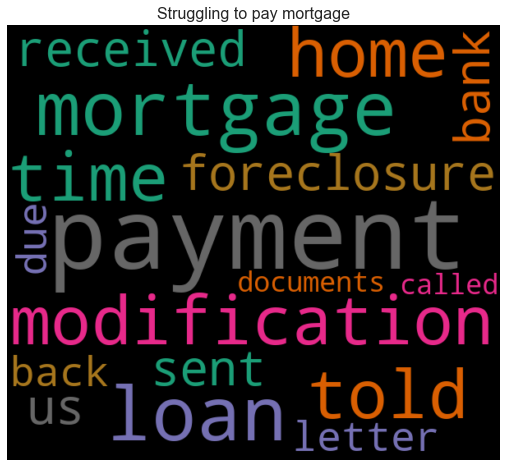

In [126]:
#Call function GenerateWordCloud
GenerateWordCloud(20)

In [ ]:
# #Attempts to collect debt not owed
# . Most correlated bigrams:
# . debt collector
# . owe debt
# . debt owed
# . attempting collect
# . debt collection
# . debt paid
# . alleged debt
# . collection agency
# . trying collect
# . collect debt

# search_words_AttemptsTo = ['debt collector','owe debt','debt owed','attempting collect','debt collection','debt paid','alleged debt','collection agency','trying collect','collect debt']
# S1 = getWordsInDFByList(complaints_ORIG, search_words_AttemptsTo, 'Attempts to collect debt not owed')
# print(S1)

## Top words in each issue Category

In [42]:
def GetTopWordsbyIssue(df, itemIssue, NumOfTopsWords):
    import nltk
    import pandas as pd
    from nltk.corpus import stopwords
    from collections import Counter

    # Load the dataframe
    df = df[df['Issue'] == itemIssue]

    # Define the stop words to exclude
    stop_words = set(stopwords.words('english'))

    # Tokenize the category column and exclude stopwords
    category_words = [word.lower() for word in nltk.word_tokenize(df['comp_cleaned'].str.cat(sep=' ')) if word.lower() not in stop_words]
    category_words
    # Retrieve the top 100 most common words
    top_words = Counter(category_words).most_common(NumOfTopsWords)
    top_words=pd.DataFrame(top_words, columns=['word','count']).sort_values(by=['count'] ,ascending=False)
    print( itemIssue + " - Top words")
    print(top_words)
    return top_words

In [28]:
IncorrectInfoWords = GetTopWordsbyIssue(complaints,'Incorrect information on your report')
IncorrectInfoWords
# IncorrectInfoWords.to_csv('../WCount/IncorrectInfoWords.csv', index=False)  

Incorrect information on your report - Top words
           word   count
0        credit  576152
1       account  348281
2        report  342119
3   information  292415
4     reporting  233173
..          ...     ...
95         last   31685
96      deleted   31366
97     personal   31349
98     required   30844
99         back   30680

[100 rows x 2 columns]


,word,count
0,credit,576152
1,account,348281
2,report,342119
3,information,292415
4,reporting,233173
...,...,...
95,last,31685
96,deleted,31366
97,personal,31349
98,required,30844


In [30]:
AttemptsToCollect =GetTopWordsbyIssue(complaints,'Attempts to collect debt not owed')
AttemptsToCollect
# AttemptsToCollect.to_csv('../WCount/AttemptsToCollect.csv', index=False)  

Attempts to collect debt not owed - Top words
           word   count
0        credit  138483
1          debt  128909
2       account  105018
3   information   69883
4        report   65370
..          ...     ...
95         mail   10155
96        could   10146
97         mine   10019
98    financial    9943
99       rights    9918

[100 rows x 2 columns]


,word,count
0,credit,138483
1,debt,128909
2,account,105018
3,information,69883
4,report,65370
...,...,...
95,mail,10155
96,could,10146
97,mine,10019
98,financial,9943


In [31]:
CommTacticsWords = GetTopWordsbyIssue(complaints,'Communication tactics')
CommTacticsWords

Communication tactics - Top words
              word  count
0             debt  23697
1             call  23567
2            phone  17682
3            calls  15222
4           called  14703
..             ...    ...
95  representative   2328
96        recovery   2328
97            tell   2309
98            owed   2255
99            well   2216

[100 rows x 2 columns]


,word,count
0,debt,23697
1,call,23567
2,phone,17682
3,calls,15222
4,called,14703
...,...,...
95,representative,2328
96,recovery,2328
97,tell,2309
98,owed,2255


In [32]:
StrgleToPayMtgWords = GetTopWordsbyIssue(complaints,'Struggling to pay mortgage')
StrgleToPayMtgWords

Struggling to pay mortgage - Top words
            word  count
0           loan  42055
1       mortgage  40860
2   modification  27832
3          would  22879
4        payment  22215
..           ...    ...
95          year   4463
96        needed   4459
97           end   4412
98    mitigation   4388
99          take   4318

[100 rows x 2 columns]


,word,count
0,loan,42055
1,mortgage,40860
2,modification,27832
3,would,22879
4,payment,22215
...,...,...
95,year,4463
96,needed,4459
97,end,4412
98,mitigation,4388


In [33]:
FraudScamWords = GetTopWordsbyIssue(complaints,'Fraud or scam')
FraudScamWords

Fraud or scam - Top words
       word  count
0   account  27489
1     money  21446
2      bank  20295
3     would  10900
4      sent   9965
..      ...    ...
95      new   2284
96   online   2235
97  deposit   2191
98        #   2188
99    zelle   2188

[100 rows x 2 columns]


,word,count
0,account,27489
1,money,21446
2,bank,20295
3,would,10900
4,sent,9965
...,...,...
95,new,2284
96,online,2235
97,deposit,2191
98,#,2188
